In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [38]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the validation dataset
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [39]:
# Load the model params
model_dict = torch.load('./models/mnist_cnn.pt')

In [40]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First conv layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Second conv layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flatten layer
        self.flatten = nn.Flatten()
        # Linear layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # Dropout
        self.dropout = nn.Dropout(0.3)
        # ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # Convolution 1 and pooling
        x = self.pool(self.relu(self.conv2(x))) # Convolution 2 and pooling
        x = self.flatten(x) # Flatten the output for the linear layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()
model.load_state_dict(model_dict)

<All keys matched successfully>

In [41]:
# Evaluate the model on the validation dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in val_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on validation data: {accuracy:.2f}%')

Accuracy on validation data: 99.24%


In [42]:
images = []
confidences = [0 for _ in range(10)]

for i in range(10):
    # Now, fix the parameters, and train an input that gives 5
    train_image = torch.randn((1, 28, 28), requires_grad=True)
    optimizer = optim.AdamW([train_image], lr=1e-2)
    criterion = nn.CrossEntropyLoss()
    target = torch.tensor([i]) # The target label to train for

    # Train the input
    num_epochs = 50
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_image.unsqueeze(0))
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
            
    # Evaluate the trained input on the model
    images.append(train_image)

In [43]:
# Calculate the confidence of each image
for i in range(10):
    output = model(images[i].unsqueeze(0))
    confidences[i] = torch.softmax(output, dim=1)[0][i].item()
    

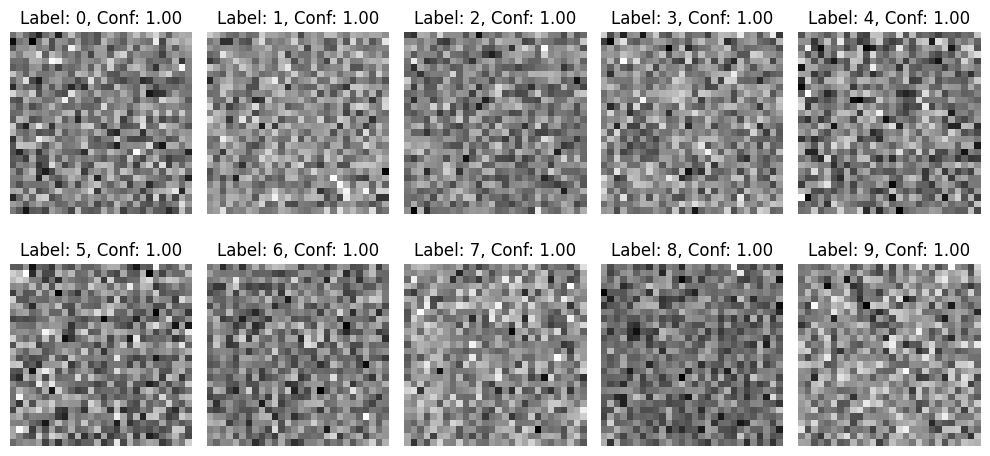

In [47]:
# Visualize all the images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(images[i*5+j].detach().numpy().squeeze(), cmap='gray')
        ax[i][j].set_title(f'Label: {i*5+j}, Conf: {confidences[i*5+j]:.2f}')
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

# save the plot
fig.savefig('./images/mnist_confidence.png')
